# Model Comparison

* Embeddings
* Embeddings + TF-IDF + LIWC
* TF-IDF + LIWC

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
import ComparisonTools


In [2]:
# First Round
cls = torch.load(f'DATA/llm-detect-ai-generated-text/features_output/dataset_8_null_removed.pt')
cls=pd.DataFrame(cls.numpy())
cls.columns = [f'CLS_{x}' for x in cls.columns]

df = pd.read_csv(f'DATA/llm-detect-ai-generated-text/dataset_9_2.csv')
labels=df['label']
df.drop(columns='label', inplace=True)
# Second Round
df2=df.join(cls)


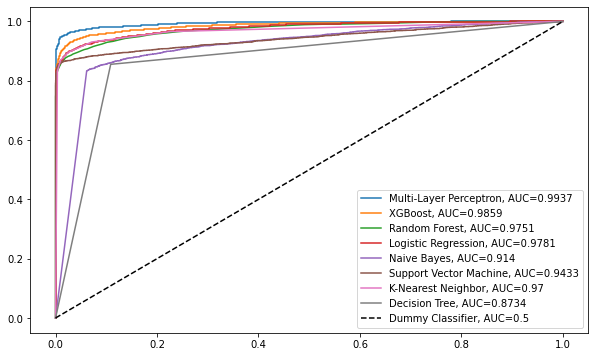

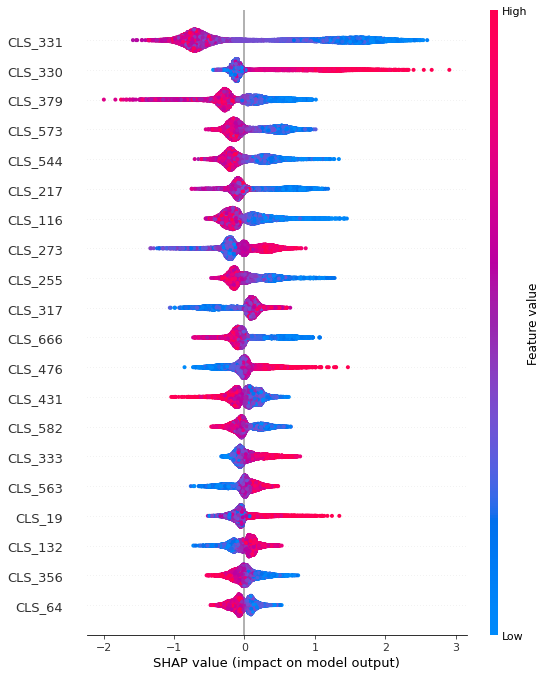

In [3]:
first_round = ComparisonTools.fit_and_score(cls,labels)

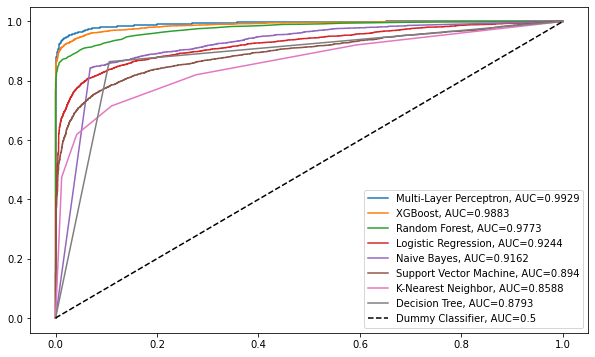

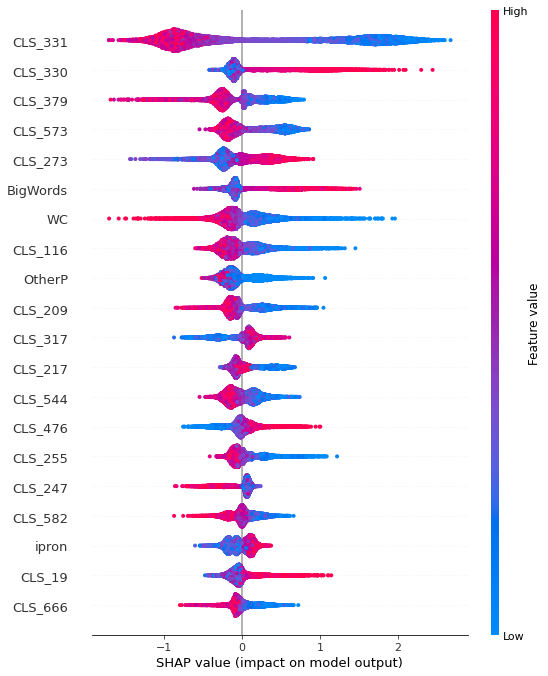

In [4]:
second_round = ComparisonTools.fit_and_score(df2,labels)

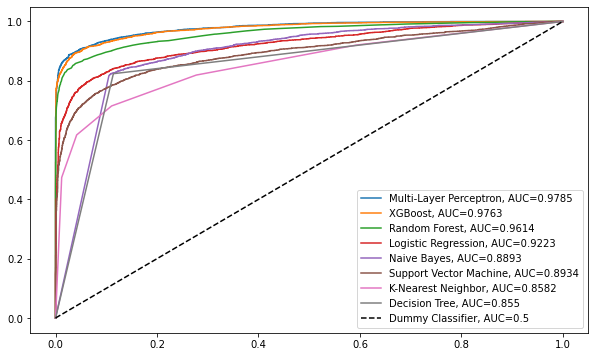

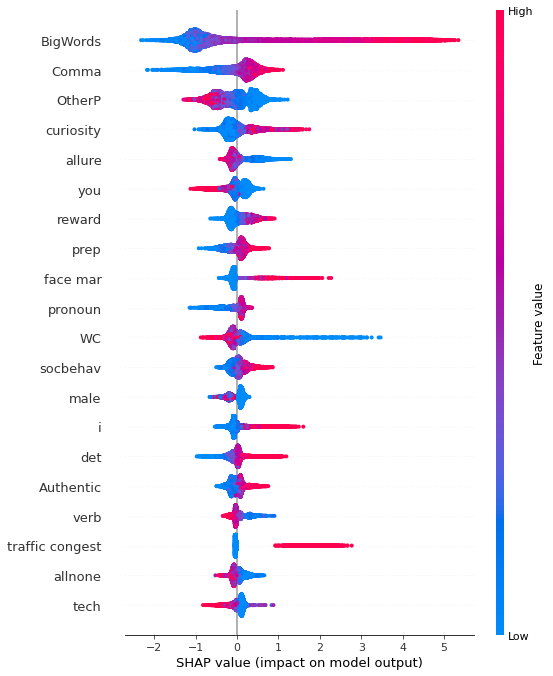

In [5]:
third_round = ComparisonTools.fit_and_score(df,labels)

In [6]:
first_round['group']  = 1
second_round['group'] = 2
third_round['group']  = 3

In [7]:
comparison=pd.concat([first_round,second_round,third_round])

In [8]:
# Overall Performance by Predictor Set
comparison.groupby('group').mean()

,Accuracy,Precision,Recall,F1_score
group,,,,
1,0.929336,0.943304,0.885417,0.912827
2,0.897030,0.906775,0.838221,0.870157
3,0.878292,0.881288,0.819351,0.847633


In [9]:
# Individual Performance Ranking
comparison.sort_values(['Accuracy','F1_score'],ascending=False)

,Accuracy,Precision,Recall,F1_score,group
Multi-Layer Perceptron,0.971801,0.981776,0.949679,0.965461,1
Multi-Layer Perceptron,0.965150,0.966384,0.949038,0.957633,2
XGBoost,0.956770,0.979746,0.914744,0.946130,2
XGBoost,0.952514,0.980188,0.903846,0.940470,1
KNN,0.942006,0.961168,0.896474,0.927695,1
Logistic Regression,0.941873,0.961472,0.895833,0.927493,1
Random Forest,0.938281,0.987877,0.861859,0.920575,2
Random Forest,0.936020,0.983510,0.860256,0.917764,1
Support Vector Machine,0.935754,0.982084,0.860897,0.917506,1
XGBoost,0.932429,0.956643,0.876923,0.915050,3


# Final Model Interpretation

* XGBoost Performance Confusion Matrix
* Total Model Feature Impact
* Single Use Case Explanations

In [10]:
from visuals_package import heat_it
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import shap

In [11]:
# Text References for Examples
Text_Ref = pd.read_csv(f"DATA/llm-detect-ai-generated-text/final_data_text_ref.csv")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.3, random_state = 42)


# Fit model to TF-IDF and LIWC-22 predictors
xgb = xgboost.XGBClassifier(tree_method="hist", early_stopping_rounds=20, random_state=42, objective='binary:logistic')
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

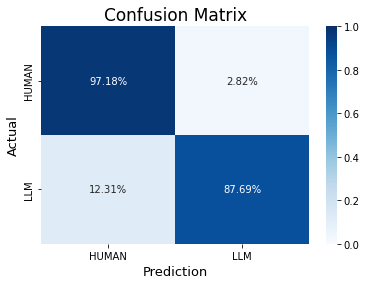

Accuracy   : 0.9324288374567704
Precision : 0.9566433566433566
Recall    : 0.8769230769230769
F1-score  : 0.9150501672240803


In [12]:
ComparisonTools.confusion_scores(xgb, X_test, y_test)

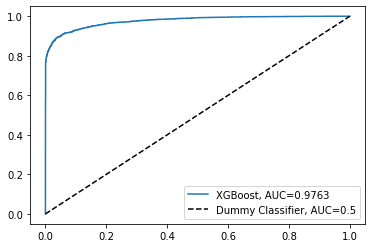

In [13]:
# Add dummy classifier line to AUC-ROC
dummy_clf= DummyClassifier(random_state = 42, strategy='most_frequent')
dummy_clf.fit(X_train,y_train)

ComparisonTools.add_roc(xgb,'XGBoost', X_test,y_test)
ComparisonTools.add_dummy(dummy_clf, X_test,y_test)

plt.legend()
plt.show()

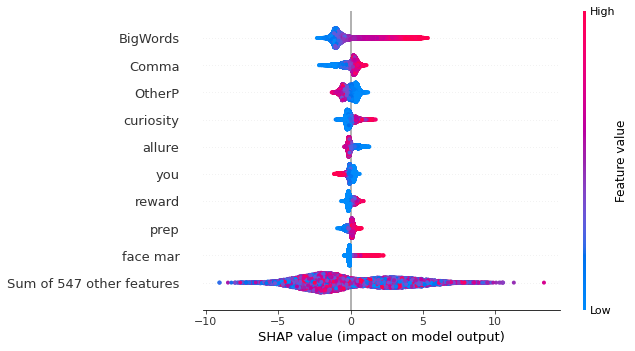

In [14]:
explainer = shap.Explainer(xgb)
shap_obj = explainer(df)

shap.plots.beeswarm(shap_obj)

## Model Prediction: LLM
Large percentage (44.4%) of words in essay are greater than six letters. 

While technology to read human emotions could have some potential benefits, using facial recognition in classrooms raises serious ethical concerns that outweigh those benefits. 

Some possible benefits come to mind. Teachers may gain insights into how students are feeling about lessons and adjusting instruction accordingly. Struggling students who are anxious or bored may be identified earlier to provide help. However, these benefits rely on assumptions that facial expressions always and accurately reveal inner emotions, which is questionable.

More importantly, this technology threatens student privacy and autonomy in very problematic ways. Continuous monitoring of students' facial expressions throughout class would amount to surveillance. It risks conditioning self-censorship, as students feel pressure to mask any reactions seen as negative by algorithms. Students deserve a learning environment where they can freely process new ideas without fear of being constantly watched and judge

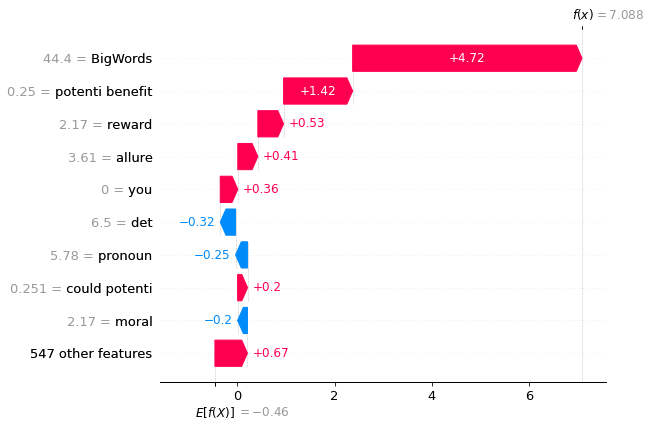

In [15]:
print(Text_Ref.iloc[15469]['text'])
shap.plots.waterfall(shap_obj[15469])

## Model Prediction: Student
Accumulation of minimally impacting features. Top 3 most impactful are bigram TF-IDF values.

We need to keep the Electoral College , it has been used by the founding fathers back then and still should be used to this day. The Electoral college is a compromise between election of the president by a vote in congress and election of the president by a popular vote of qualified citizens. It also helps by the process of selection of the electors , were the vote for president and vice president. The Electoral College can keep five hundred and thirty eight electors with two hundred and seventy electoral votes to require the president. For each state has his or her own group of electors chosen by the candidate's political party.

The presidential election is held every four years on a tuesday after the first monday in november. What most states do is have a "winner-take-all" system that awards all electors to the winning presidential candidate. Then win the election is over the governor prepares a "Certificate of Ascertainment"with every candidate who ran for president names on it. Th

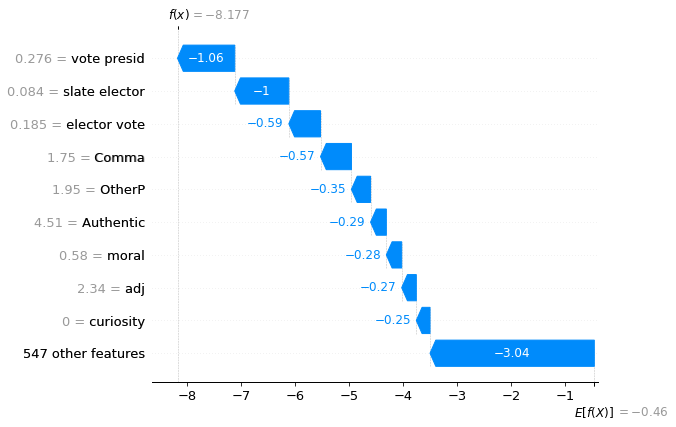

In [16]:
print(Text_Ref.iloc[8115]['text'])
shap.plots.waterfall(shap_obj[8115])